In [1]:
# https://blog.keras.io/building-autoencoders-in-keras.html

import os
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend' # https://github.com/plaidml/plaidml/blob/master/docs/index.md

from keras.models import Model, save_model, load_model
from keras.layers import Input, Dense
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.callbacks import TensorBoard

Using plaidml.keras.backend backend.


In [2]:
MODEL_VERSION = 'v2'
INPUT_SIZE = (784,)
BOTTLENECK_DIM = 64
BOTTLENECK_SIZE = (BOTTLENECK_DIM,)

In [3]:
# Autoencoder Architecture
input_img = Input(shape=INPUT_SIZE)
x = Dense(256, activation='relu')(input_img)
x = Dense(128, activation='relu')(x)
encoded = Dense(BOTTLENECK_DIM, activation='relu')(x)

x = Dense(128, activation='relu')(encoded)
x = Dense(256, activation='relu')(x)
decoded = Dense(784, activation='sigmoid')(x)

# Autoencoder Model
autoencoder = Model(input_img, decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # use binary_crossentropy, mean_squared_error doesnt work
autoencoder.run_eagerly = True # plaidml / keras not running eager mode by default

# Encoder Architecture
Elayer_input = Input(shape=INPUT_SIZE) # layer start from 0
x = autoencoder.layers[1](Elayer_input)
x = autoencoder.layers[2](x)
Elayer_output = autoencoder.layers[3](x)

# Encoder Model
encoder = Model(Elayer_input, Elayer_output, name='encoder')

# Decoder Architecture
Dlayer_input = Input(shape=BOTTLENECK_SIZE) # use model.summary() to check input_shape
x = autoencoder.layers[-3](Dlayer_input)
x = autoencoder.layers[-2](x)
Dlayer_output = autoencoder.layers[-1](x) # extract last layer, start from -1

# Decoder Model
decoder = Model(Dlayer_input, Dlayer_output, name='decoder')

# Remove unused variable to reduce RAM usage
del x, input_img, encoded, decoded, Elayer_input, Elayer_output, Dlayer_input, Dlayer_output

INFO:plaidml:Opening device "opencl_intel_hd_graphics_4000.0"


In [4]:
# use model.summary() or data.shape() to find shape
autoencoder.summary()
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               201488    
Total para

In [5]:
%%time
import numpy as np

# Load mnist dataset
(x_train, _),(x_test, _) = mnist.load_data()

# Preprocess
x_train = x_train.astype('float32')/255 # normalise to 0 and 1
x_test  = x_test.astype('float32')/255
x_train = x_train.reshape(len(x_train), (np.prod(x_train.shape[1:]))) # 28x28 flatten into 1x784
x_test  = x_test.reshape(len(x_test), (np.prod(x_test.shape[1:])))

print(f'x_train shape = {x_train.shape}') # 60000 images 784 vectors = 60000 row 784 col
print(f'x_test shape = {x_test.shape}') # 10000 images 784 vectors = 10000 row 784 col

x_train shape = (60000, 784)
x_test shape = (10000, 784)
Wall time: 496 ms


In [6]:
%%time
import os
import time

CURRENT_TIME = int(time.time())
print(CURRENT_TIME)

try:
    os.makedirs(f'autoencoder{MODEL_VERSION}/logs-{CURRENT_TIME}')
except Exception:
    pass

try:
    os.makedirs(f'autoencoder{MODEL_VERSION}/checkpoint-{CURRENT_TIME}')
except Exception:
    pass

# Run this in a terminal
#tensorboard --logdir=autoencoder/logs

CALLBACKS=[
    TensorBoard(log_dir=f'autoencoder{MODEL_VERSION}/logs-{CURRENT_TIME}'),
    ModelCheckpoint(filepath=f'autoencoder{MODEL_VERSION}/checkpoint-{CURRENT_TIME}'+'/'
                             +'model.{epoch:003d}-{val_loss:.4f}.h5',
                    verbose=1, save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
]

# Fit data
training = autoencoder.fit(x_train, x_train,
                           validation_data=(x_test, x_test),
                           epochs=100, batch_size=32, shuffle=True,
                           callbacks=CALLBACKS) # 50 epochs, 256 bs; 100 epochs; 32 bs

print(CURRENT_TIME)

1595007482
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 74s 1ms/step - loss: 0.1292 - val_loss: 0.0971

Epoch 00001: val_loss improved from inf to 0.09707, saving model to autoencoderv2/checkpoint-1595007482/model.001-0.0971.h5
Epoch 2/100
60000/60000 [==============================] - 68s 1ms/step - loss: 0.0924 - val_loss: 0.0873

Epoch 00002: val_loss improved from 0.09707 to 0.08729, saving model to autoencoderv2/checkpoint-1595007482/model.002-0.0873.h5
Epoch 3/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0860 - val_loss: 0.0839

Epoch 00003: val_loss improved from 0.08729 to 0.08386, saving model to autoencoderv2/checkpoint-1595007482/model.003-0.0839.h5
Epoch 4/100
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0826 - val_loss: 0.0814

Epoch 00004: val_loss improved from 0.08386 to 0.08145, saving model to autoencoderv2/checkpoint-1595007482/model.004-0.0814.h5
Epo

In [15]:
%%time
import os

try:
    os.makedirs(f'autoencoder{MODEL_VERSION}/model')
except Exception:
    pass

save_model(autoencoder, f'autoencoder{MODEL_VERSION}/model/autoencoder{MODEL_VERSION}-last_train.h5')
save_model(encoder, f'autoencoder{MODEL_VERSION}/model/encoder{MODEL_VERSION}-last_train.h5')
save_model(decoder, f'autoencoder{MODEL_VERSION}/model/decoder{MODEL_VERSION}-last_train.h5')

Wall time: 2.15 s


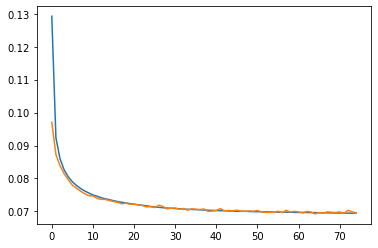

In [7]:
# need to put training = autoencoder.fit(...) first
import matplotlib.pyplot as plt

plt.plot(training.history['loss'], label='train')
plt.plot(training.history['val_loss'], label='test')
plt.show()

In [8]:
%%time
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Wall time: 4.22 s


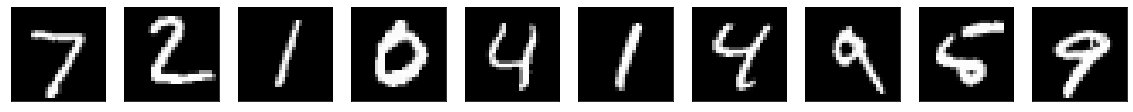

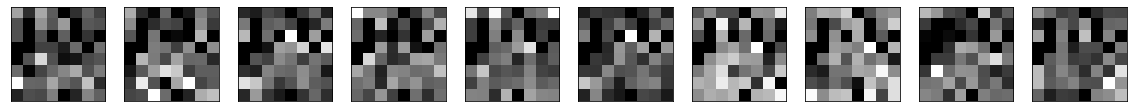

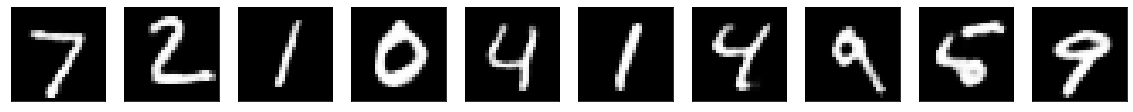

Wall time: 1.72 s


In [52]:
%%time
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # What does encoded images looks like?
    ax = plt.subplot(3, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(8*1,8)) # encoded 64 # (8,8) # (4, 4*4)
    #plt.imshow(decoded_imgs[i].reshape(4, 14*14).T) # input or decoded 784 # (28,28) # (4, 14*14)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [54]:
%%time
# https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
def mse(img1, img2):
    return np.mean( (img1 - img2) ** 2 )

def psnr(img1, img2):
    mserr = mse(img1, img2)
    PIXEL_MAX = 1.0
    try:
        return 20 * math.log10(PIXEL_MAX / math.sqrt(mserr))
    except ZeroDivisionError:
        return 'Same image'

n = 10
for i in range(n):
    original = x_test[i]
    contrast = decoded_imgs[i]
    a = mse(original, contrast)
    b = psnr(original, contrast) # can also use cv2.PSNR rather than defined function psnr
    if b != 'Same image':
        print(f'MSE = {a:.4f}, PSNR (dB) = {b:.2f}')
    else:
        print(f'MSE = {a:.4f}, PSNR too high')

MSE = 0.0014, PSNR (dB) = 28.68
MSE = 0.0049, PSNR (dB) = 23.07
MSE = 0.0007, PSNR (dB) = 31.69
MSE = 0.0030, PSNR (dB) = 25.25
MSE = 0.0026, PSNR (dB) = 25.92
MSE = 0.0006, PSNR (dB) = 31.88
MSE = 0.0048, PSNR (dB) = 23.17
MSE = 0.0036, PSNR (dB) = 24.49
MSE = 0.0048, PSNR (dB) = 23.21
MSE = 0.0035, PSNR (dB) = 24.56
Wall time: 7.99 ms


In [55]:
%%time
# https://github.com/imamun93/Image-Similarities-using-SSIM/blob/master/blog5_ssim.ipynb
import numpy as np
from tensorflow.image import ssim, rgb_to_yuv
from tensorflow import convert_to_tensor

n = 10
for i in range(n):
    original = x_test[i].reshape(1, 28, 28, 1)
    contrast = decoded_imgs[i].reshape(1, 28, 28, 1)
    a = np.asarray(ssim(convert_to_tensor(original), convert_to_tensor(contrast), max_val=1)) # <class 'tensorflow.python.framework.ops.EagerTensor'>
    #a = np.asarray(ssim(rgb_to_yuv(convert_to_tensor(original)), rgb_to_yuv(convert_to_tensor(contrast)), max_val=1))
    print(f'{a[0]:.4f}')

0.9834
0.9632
0.9903
0.9734
0.9687
0.9924
0.9357
0.9684
0.9584
0.9698
Wall time: 229 ms


In [56]:
%%time
# https://github.com/tensorflow/models/blob/master/research/compression/image_encoder/msssim.py
import numpy as np
from scipy import signal
from scipy.ndimage.filters import convolve

def _FSpecialGauss(size, sigma):
  """Function to mimic the 'fspecial' gaussian MATLAB function."""
  radius = size // 2
  offset = 0.0
  start, stop = -radius, radius + 1
  if size % 2 == 0:
    offset = 0.5
    stop -= 1
  x, y = np.mgrid[offset + start:stop, offset + start:stop]
  assert len(x) == size
  g = np.exp(-((x**2 + y**2)/(2.0 * sigma**2)))
  return g / g.sum()


def _SSIMForMultiScale(img1, img2, max_val=255, filter_size=11,
                       filter_sigma=1.5, k1=0.01, k2=0.03):
  """Return the Structural Similarity Map between `img1` and `img2`.
  This function attempts to match the functionality of ssim_index_new.m by
  Zhou Wang: http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
  Arguments:
    img1: Numpy array holding the first RGB image batch.
    img2: Numpy array holding the second RGB image batch.
    max_val: the dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
    filter_size: Size of blur kernel to use (will be reduced for small images).
    filter_sigma: Standard deviation for Gaussian blur kernel (will be reduced
      for small images).
    k1: Constant used to maintain stability in the SSIM calculation (0.01 in
      the original paper).
    k2: Constant used to maintain stability in the SSIM calculation (0.03 in
      the original paper).
  Returns:
    Pair containing the mean SSIM and contrast sensitivity between `img1` and
    `img2`.
  Raises:
    RuntimeError: If input images don't have the same shape or don't have four
      dimensions: [batch_size, height, width, depth].
  """
  if img1.shape != img2.shape:
    raise RuntimeError('Input images must have the same shape (%s vs. %s).',
                       img1.shape, img2.shape)
  if img1.ndim != 4:
    raise RuntimeError('Input images must have four dimensions, not %d',
                       img1.ndim)

  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)
  _, height, width, _ = img1.shape

  # Filter size can't be larger than height or width of images.
  size = min(filter_size, height, width)

  # Scale down sigma if a smaller filter size is used.
  sigma = size * filter_sigma / filter_size if filter_size else 0

  if filter_size:
    window = np.reshape(_FSpecialGauss(size, sigma), (1, size, size, 1))
    mu1 = signal.fftconvolve(img1, window, mode='valid')
    mu2 = signal.fftconvolve(img2, window, mode='valid')
    sigma11 = signal.fftconvolve(img1 * img1, window, mode='valid')
    sigma22 = signal.fftconvolve(img2 * img2, window, mode='valid')
    sigma12 = signal.fftconvolve(img1 * img2, window, mode='valid')
  else:
    # Empty blur kernel so no need to convolve.
    mu1, mu2 = img1, img2
    sigma11 = img1 * img1
    sigma22 = img2 * img2
    sigma12 = img1 * img2

  mu11 = mu1 * mu1
  mu22 = mu2 * mu2
  mu12 = mu1 * mu2
  sigma11 -= mu11
  sigma22 -= mu22
  sigma12 -= mu12

  # Calculate intermediate values used by both ssim and cs_map.
  c1 = (k1 * max_val) ** 2
  c2 = (k2 * max_val) ** 2
  v1 = 2.0 * sigma12 + c2
  v2 = sigma11 + sigma22 + c2
  ssim = np.mean((((2.0 * mu12 + c1) * v1) / ((mu11 + mu22 + c1) * v2)))
  cs = np.mean(v1 / v2)
  return ssim, cs


def MultiScaleSSIM(img1, img2, max_val=255, filter_size=11, filter_sigma=1.5,
                   k1=0.01, k2=0.03, weights=None):
  """Return the MS-SSIM score between `img1` and `img2`.
  This function implements Multi-Scale Structural Similarity (MS-SSIM) Image
  Quality Assessment according to Zhou Wang's paper, "Multi-scale structural
  similarity for image quality assessment" (2003).
  Link: https://ece.uwaterloo.ca/~z70wang/publications/msssim.pdf
  Author's MATLAB implementation:
  http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
  Arguments:
    img1: Numpy array holding the first RGB image batch.
    img2: Numpy array holding the second RGB image batch.
    max_val: the dynamic range of the images (i.e., the difference between the
      maximum the and minimum allowed values).
    filter_size: Size of blur kernel to use (will be reduced for small images).
    filter_sigma: Standard deviation for Gaussian blur kernel (will be reduced
      for small images).
    k1: Constant used to maintain stability in the SSIM calculation (0.01 in
      the original paper).
    k2: Constant used to maintain stability in the SSIM calculation (0.03 in
      the original paper).
    weights: List of weights for each level; if none, use five levels and the
      weights from the original paper.
  Returns:
    MS-SSIM score between `img1` and `img2`.
  Raises:
    RuntimeError: If input images don't have the same shape or don't have four
      dimensions: [batch_size, height, width, depth].
  """
  if img1.shape != img2.shape:
    raise RuntimeError('Input images must have the same shape (%s vs. %s).',
                       img1.shape, img2.shape)
  if img1.ndim != 4:
    raise RuntimeError('Input images must have four dimensions, not %d',
                       img1.ndim)

  # Note: default weights don't sum to 1.0 but do match the paper / matlab code.
  weights = np.array(weights if weights else
                     [0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
  levels = weights.size
  downsample_filter = np.ones((1, 2, 2, 1)) / 4.0
  im1, im2 = [x.astype(np.float64) for x in [img1, img2]]
  mssim = np.array([])
  mcs = np.array([])
  for _ in range(levels):
    ssim, cs = _SSIMForMultiScale(
        im1, im2, max_val=max_val, filter_size=filter_size,
        filter_sigma=filter_sigma, k1=k1, k2=k2)
    mssim = np.append(mssim, ssim)
    mcs = np.append(mcs, cs)
    filtered = [convolve(im, downsample_filter, mode='reflect')
                for im in [im1, im2]]
    im1, im2 = [x[:, ::2, ::2, :] for x in filtered]
  return (np.prod(mcs[0:levels-1] ** weights[0:levels-1]) *
          (mssim[levels-1] ** weights[levels-1]))

n = 10
for i in range(n):
    original = x_test[i].reshape(1, 28, 28, 1)
    contrast = decoded_imgs[i].reshape(1, 28, 28, 1)
    a = MultiScaleSSIM(original, contrast, max_val=1.0)
    print(f'{a:.4f}')

0.9983
0.9889
0.9967
0.9963
0.9944
0.9988
0.9845
0.9922
0.9918
0.9916
Wall time: 113 ms


In [36]:
%%time
import os

try:
    os.makedirs(f'autoencoder{MODEL_VERSION}/model')
except Exception:
    pass

save_model(autoencoder, f'autoencoder{MODEL_VERSION}/model/autoencoder{MODEL_VERSION}-784-256-128-64-128-256-784-best.h5')
save_model(encoder, f'autoencoder{MODEL_VERSION}/model/encoder{MODEL_VERSION}-784-256-128-64-best.h5')
save_model(decoder, f'autoencoder{MODEL_VERSION}/model/decoder{MODEL_VERSION}-64-128-256-784-best.h5')

Wall time: 400 ms
